# Predicting Water Levels for the Auser Aquifer

## Importing libraries and dataset

In [1]:
import pandas as pd 
from datetime import datetime
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_squared_error

In [2]:
aus = pd.read_csv('Aquifer_Auser.csv')

## Performing the same initial transformations as the first notebook

In [3]:
aus['Date'] = pd.to_datetime(aus['Date'], format='%d/%m/%Y')

In [4]:
abs_cols = ['Depth_to_Groundwater_LT2', 'Depth_to_Groundwater_SAL', 'Depth_to_Groundwater_PAG', 'Depth_to_Groundwater_CoS', 'Depth_to_Groundwater_DIEC',
           'Volume_POL', 'Volume_CC1', 'Volume_CC2', 'Volume_CSA', 'Volume_CSAL']
# absolute values can be taken from the above columns as clarified by competition host in a discussion thread on kaggle

In [5]:
for col in abs_cols:
    aus[col] = abs(aus[col])

## SARIMA model for Depths of SAL

In [6]:
aus_sal = aus[['Date', 'Depth_to_Groundwater_SAL']]

#### Data Cleaning

In [7]:
aus_sal.loc[aus_sal['Depth_to_Groundwater_SAL'].notnull()].head()

,Date,Depth_to_Groundwater_SAL
3319,2007-04-06,6.69
3320,2007-04-07,6.71
3321,2007-04-08,6.67
3322,2007-04-09,6.62
3323,2007-04-10,6.64


In [8]:
aus_sal = aus_sal[3319:]
# Starting the dataset from the first non-null value

In [9]:
aus_sal['Depth_to_Groundwater_SAL'] = aus_sal['Depth_to_Groundwater_SAL'].replace(0, np.nan)
# 0 values are taken to be instrument failures and replaced with null

In [10]:
aus_sal['Depth_to_Groundwater_SAL'] = aus_sal['Depth_to_Groundwater_SAL'].interpolate()
# null values are filled using interpolation

In [11]:
aus_sal.isnull().sum()

Date                        0
Depth_to_Groundwater_SAL    0
dtype: int64

In [12]:
aus_sal.set_index('Date', inplace=True)

In [13]:
aus_sal = aus_sal.resample('W').mean()
# aggregating data into a weekly mean

In [14]:
aus_sal.head()

,Depth_to_Groundwater_SAL
Date,
2007-04-08,6.690000
2007-04-15,6.737143
2007-04-22,6.854286
2007-04-29,6.957143
2007-05-06,6.907143


#### Train Test Split

In [15]:
len(aus_sal)

692

In [16]:
len(aus_sal)*0.8

553.6

In [17]:
aus_sal_train = aus_sal[:553]
aus_sal_train.tail()
# Setting the initial 80% of the data as the train set

,Depth_to_Groundwater_SAL
Date,
2017-10-08,5.902857
2017-10-15,5.940000
2017-10-22,5.988571
2017-10-29,6.010000
2017-11-05,6.072857


In [18]:
aus_sal_test = aus_sal[553:]
aus_sal_test.head()
# Setting the remaining data as the test set

,Depth_to_Groundwater_SAL
Date,
2017-11-12,5.992857
2017-11-19,5.967143
2017-11-26,6.028571
2017-12-03,5.978571
2017-12-10,5.935714


In [19]:
aus_sal_train.index = pd.DatetimeIndex(aus_sal_train.index).to_period('W')
aus_sal_test.index = pd.DatetimeIndex(aus_sal_test.index).to_period('W')
# specifying frequency of the date index (required for SARIMA model)

#### Augmented Dickey-Fuller test to check for Stationarity

In [20]:
def interpret_df(df):
    dfoutput = pd.Series(df[0:2], index=['Test Statistic','p-value'])
    return dfoutput

In [21]:
interpret_df(adfuller(aus_sal_train['Depth_to_Groundwater_SAL']))

Test Statistic   -4.089970
p-value           0.001006
dtype: float64

With a p-value of 0.001006, the stationarity condition is fulfilled.

#### Checking for AR and MA lags

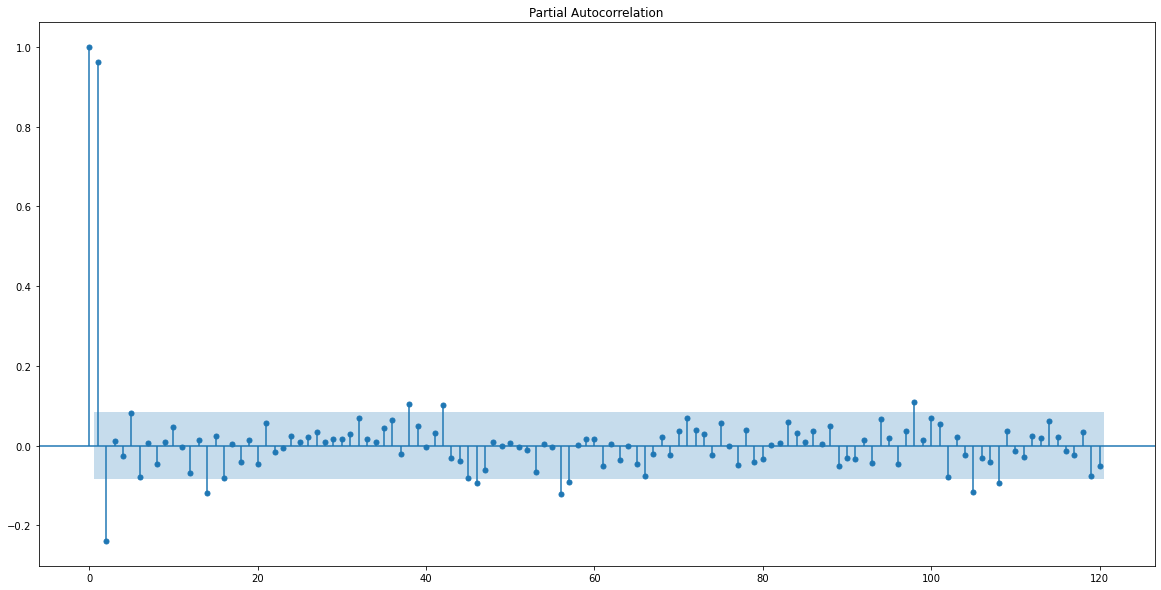

In [22]:
fig, ax = plt.subplots(figsize=(20, 10))
plot_pacf(aus_sal_train['Depth_to_Groundwater_SAL'], lags=120, ax=ax)
plt.show()

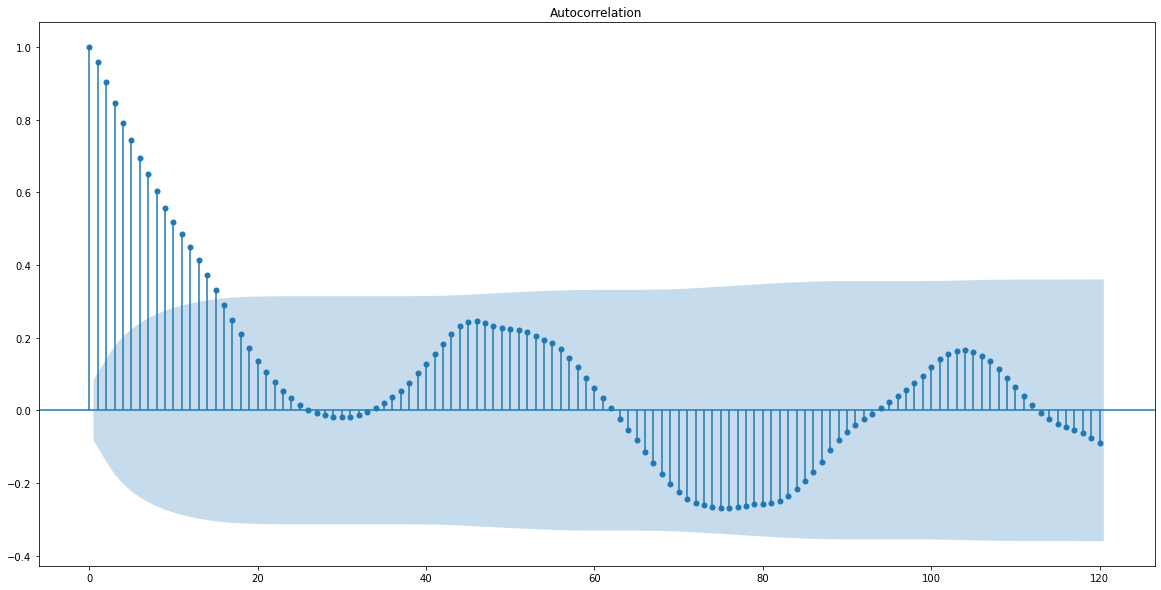

In [23]:
fig, ax = plt.subplots(figsize=(20, 10))
plot_acf(aus_sal_train['Depth_to_Groundwater_SAL'], lags=120, ax=ax)
plt.show()

The PACF curve shows a sharp cut-off at the 2nd lag while the ACF curve shows a gradual decay. 

Since Stationarity has been fulfilled as shown earlier, the (p, d, q) will be set as (2, 0, 0)

The length of season will be set to a year, or in this case, 52 weeks. This trend can roughly be seen from the ACF plot as well.

#### Gridsearching seasonal_order parameters for SARIMA model

In [24]:
# Starting MSE and (P, D, Q).
final_p = 0
final_d = 0
final_q = 0

mse = 10**16

for P in range(3):
    for Q in range(3):
        for D in range(3):
            try:
                # Instantiate SARIMA model.
                sarima = SARIMAX(endog = aus_sal_train['Depth_to_Groundwater_SAL'],
                                 order = (2, 0, 0),              # (p, d, q)
                                 seasonal_order = (P, D, Q, 52)) # (P, D, Q, S)

                # Fit SARIMA model.
                model = sarima.fit()

                # Generate predictions based on training set.
                # Start at time period 0 and end at 552.
                preds = model.predict(start=0, end=552)

                # Evaluate predictions.
                print(f'The MSE for (2, 0, 0)x({P},{D},{Q},52) is: {mean_squared_error(aus_sal_train["Depth_to_Groundwater_SAL"], preds)}')
                
                # Save for final report.
                if mse > mean_squared_error(aus_sal_train['Depth_to_Groundwater_SAL'], preds):
                    
                    mse =  mean_squared_error(aus_sal_train['Depth_to_Groundwater_SAL'], preds)
                    final_P = P
                    final_D = D
                    final_Q = Q

                
            except:
                pass

print(f'Our model that minimizes MSE on the training data is the SARIMA(2, 0, 0)x({final_P},{final_D},{final_Q},52).')
print(f'This model has an MSE of {mse}.')

The MSE for (2, 0, 0)x(0,0,0,52) is: 0.10634743966609117
The MSE for (2, 0, 0)x(0,1,0,52) is: 4.161877706680601
The MSE for (2, 0, 0)x(0,2,0,52) is: 5.898068112157095
The MSE for (2, 0, 0)x(0,0,1,52) is: 0.10629463152204574
The MSE for (2, 0, 0)x(0,1,1,52) is: 4.147059226476444
The MSE for (2, 0, 0)x(0,2,1,52) is: 5.838463352682519


C:\Users\jonat\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1006: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


The MSE for (2, 0, 0)x(0,0,2,52) is: 0.10609057792666837
The MSE for (2, 0, 0)x(0,1,2,52) is: 4.147030403877382


C:\Users\jonat\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1006: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


The MSE for (2, 0, 0)x(0,2,2,52) is: 5.830982359284344
The MSE for (2, 0, 0)x(1,0,0,52) is: 0.10628533911594472
The MSE for (2, 0, 0)x(1,1,0,52) is: 4.150952506677218
The MSE for (2, 0, 0)x(1,2,0,52) is: 5.847526499278063
The MSE for (2, 0, 0)x(1,0,1,52) is: 0.10629038904679959
The MSE for (2, 0, 0)x(1,1,1,52) is: 4.147020119451283


C:\Users\jonat\anaconda3\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


The MSE for (2, 0, 0)x(1,2,1,52) is: 5.831580010641998
The MSE for (2, 0, 0)x(1,0,2,52) is: 0.10626876960687906


C:\Users\jonat\anaconda3\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


The MSE for (2, 0, 0)x(1,1,2,52) is: 4.147001296487007


C:\Users\jonat\anaconda3\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


The MSE for (2, 0, 0)x(1,2,2,52) is: 5.8309650464036675
The MSE for (2, 0, 0)x(2,0,0,52) is: 0.10609869443773905
The MSE for (2, 0, 0)x(2,1,0,52) is: 4.149623835709822
The MSE for (2, 0, 0)x(2,2,0,52) is: 5.839179173254335


C:\Users\jonat\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:994: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
C:\Users\jonat\anaconda3\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


The MSE for (2, 0, 0)x(2,0,1,52) is: 0.10599726522298412


C:\Users\jonat\anaconda3\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


The MSE for (2, 0, 0)x(2,1,1,52) is: 4.146842835083072


C:\Users\jonat\anaconda3\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


The MSE for (2, 0, 0)x(2,2,1,52) is: 5.831191701251342


C:\Users\jonat\anaconda3\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


The MSE for (2, 0, 0)x(2,0,2,52) is: 0.10621045112184163
The MSE for (2, 0, 0)x(2,1,2,52) is: 4.146775097417508


C:\Users\jonat\anaconda3\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


The MSE for (2, 0, 0)x(2,2,2,52) is: 5.8308037279106815
Our model that minimizes MSE on the training data is the SARIMA(2, 0, 0)x(2,0,1,52).
This model has an MSE of 0.10599726522298412.


#### Fitting Sarima model, generating predictions and computing RMSE

In [29]:
sarima = SARIMAX(endog = aus_sal_train['Depth_to_Groundwater_SAL'],
                order = (2, 0, 0),
                seasonal_order = (2, 0, 1, 52))

In [30]:
preds = model.predict(start=553, end=691)

In [27]:
print(np.sqrt(mean_squared_error(aus_sal_test['Depth_to_Groundwater_SAL'], preds)))

0.4351898319305505


In [32]:
0.4351898319305505/0.642939
# standard deviation from first notebook

0.6768757719325635

Use of SARIMA model yields an RMSE which is 68% of the standard deviation.